In [23]:
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from statistics import mean



import gdoom

#VI LAVER VIZDOOM
env = gym.make("doom_scenario2_96-v0")

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display
plt.style.use('ggplot')
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 10)

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


C:\Users\Frederik\Anaconda3\lib\site-packages\gym\logger.py:30: UserWarning: WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Doom> Loading level: C:\Users\Frederik\Anaconda3\lib\site-packages\vizdoom/scenarios/defend_the_center.cfg


In [24]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [25]:
#print(env.get_available_game_varialbes())

In [26]:
resize = T.Compose([T.ToPILImage(),
                    T.Resize(40, interpolation=Image.CUBIC),
                    T.ToTensor()])


def get_screen(x):
    
    x = np.array(x)
    screen = x.transpose((2,0,1)) 
    
    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
    screen = torch.from_numpy(screen)
    
    return resize(screen).unsqueeze(0).to(device)


In [5]:
p = 0.2
end_out = 64
num_frames = 4


##Ændre Conv1 til (4,32,osv). np.array(x[0]) har (96,96,4) som dimensions

class DQN(nn.Module):

    def __init__(self, h, w,outputs):
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(num_frames, 16, kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, end_out, kernel_size=5, stride=2)
        self.bn3 = nn.BatchNorm2d(end_out)
        self.dropout = nn.Dropout(p)
        
        
        def conv2d_size_out(size, kernel_size = 5, stride = 2):
            return (size - (kernel_size - 1) - 1) // stride  + 1
        convw = conv2d_size_out(conv2d_size_out(conv2d_size_out(w)))
        convh = conv2d_size_out(conv2d_size_out(conv2d_size_out(h)))
        linear_input_size = convw * convh * end_out
        self.head = nn.Linear(linear_input_size, outputs)

        
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.dropout(x)
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.dropout(x)
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.dropout(x)
        
        
        
        
        return self.head(x.view(x.size(0), -1))

In [6]:
def save_modules(PATH):
    #PATH = 'C:/Users/Frederik/Desktop/Gdoom/Model/save.tar'
    torch.save({
                'model': target_net,
                'model_state_dict': target_net.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': loss_list,
                'reward': reward_list
                }, PATH)

In [7]:
BATCH_SIZE = 32
GAMMA = 0.99
EPS_START = 1.0
EPS_END = 0.01
EPS_DECAY = 1000000
TARGET_UPDATE = 5

#print(env.render().size())
init_screen = get_screen(env.reset())
_, _, screen_height, screen_width = init_screen.shape

n_actions = env.action_space.n

policy_net = DQN(screen_height, screen_width, n_actions).to(device)
target_net = DQN(screen_height, screen_width, n_actions).to(device)
#target_net.load_state_dict(policy_net.state_dict())
#target_net.eval()

optimizer = optim.RMSprop(policy_net.parameters(),lr=0.001,weight_decay=0.00001)
memory = ReplayMemory(1000000)

steps_done = 0


def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[random.randrange(n_actions)]], device=device, dtype=torch.long)


episode_durations = []


In [8]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    
    batch = Transition(*zip(*transitions))

    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.uint8)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    state_action_values = policy_net(state_batch).gather(1,action_batch)
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    _,next_state_actions = policy_net(non_final_next_states).max(1,keepdim=True)
    next_state_values[non_final_mask] = target_net(non_final_next_states).gather(1,next_state_actions).squeeze(1)
    
    
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch
    
    ## Brug MSQ Error i stedet maybe
    # Compute l1_loss
    
    loss = F.l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))
    #+ F.cross_entropy(label_values)
    
    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    loss_list.append(float(loss))
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()

In [20]:
num_episodes = 101
reward_list = list()
loss_list = list()
reward_batch = list()
final_info = list()

#PATH = 'C:/Users/marcv/Desktop/DoomSave/saveV2.tar'
PATH = 'C:/Users/Frederik/Desktop/Gdoom/Model/saveV2.tar'
#checkpoint = torch.load(PATH)
#target_net.load_state_dict(checkpoint['model_state_dict'])
#optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
#reward_list = checkpoint['reward']
#loss_list = checkpoint['loss']


for i_episode in range(num_episodes):
    frame = env.reset()
    last_screen = get_screen(frame)
    current_screen = get_screen(frame)
    state = current_screen
    acc_reward = 0
  #  print(state)
    for t in count():
        action = select_action(state)
        #
        frame, reward, done, info = env.step(action.item())
        reward = torch.tensor([reward], device=device)
        acc_reward += reward
       # print(info)
        #print(info)
        print(str(reward.cpu().numpy()) + " " + str(acc_reward.cpu().numpy()))

        last_screen = current_screen
        current_screen = get_screen(frame)
        if not done:
            next_state = current_screen
        else:
            next_state = None

        memory.push(state, action, next_state, reward)

        state = next_state

        optimize_model()
        if done:
            episode_durations.append(t + 1)
            final_info.append(info)
            break
    reward_list.append(float(acc_reward))
    
    if i_episode % TARGET_UPDATE == 0:
        #print(i_episode)
        target_net.load_state_dict(policy_net.state_dict())
    if i_episode/10 % TARGET_UPDATE == 0:
        if i_episode != 0:
            reward_batch.append(sum(reward_list[-TARGET_UPDATE*10:])/(TARGET_UPDATE*10))
            print("COMPLETE! " + ", Episode: " + str(i_episode) + ", Cumm. Reward: " + str(reward_batch[-1:]))
    save_modules(PATH)
        
print('Complete')
#env.render()
env.close()
#plt.ioff()
#plt.show(

[0.] [0.]
[0.] [0.]
[-0.1] [-0.1]
[0.] [-0.1]
[0.] [-0.1]
[0.] [-0.1]
[0.] [-0.1]
[0.] [-0.1]
[0.] [-0.1]
[0.] [-0.1]
[0.] [-0.1]
[-0.1] [-0.2]
[0.] [-0.2]
[0.] [-0.2]
[-0.1] [-0.3]
[0.] [-0.3]
[0.] [-0.3]
[0.] [-0.3]
[-0.1] [-0.4]
[0.] [-0.4]
[0.] [-0.4]
[0.] [-0.4]
[-0.1] [-0.5]
[0.] [-0.5]
[0.] [-0.5]
[0.] [-0.5]
[0.] [-0.5]
[0.] [-0.5]
[1.9] [1.4]
[0.] [1.4]
[0.] [1.4]
[-0.1] [1.3]
[0.] [1.3]
[0.] [1.3]
[0.] [1.3]
[0.] [1.3]
[0.] [1.3]
[-0.1] [1.1999999]
[0.] [1.1999999]
[0.] [1.1999999]
[0.] [1.1999999]
[-0.1] [1.0999999]
[0.] [1.0999999]
[-0.1] [0.9999999]
[0.] [0.9999999]
[-0.1] [0.89999986]
[0.] [0.89999986]
[0.] [0.89999986]
[-0.1] [0.79999983]
[0.] [0.79999983]
[0.] [0.79999983]
[-0.1] [0.6999998]
[0.] [0.6999998]
[-0.1] [0.5999998]
[0.] [0.5999998]
[-0.1] [0.4999998]
[0.] [0.4999998]
[0.] [0.4999998]
[0.] [0.4999998]
[0.] [0.4999998]
[1.9] [2.3999999]
[0.] [2.3999999]
[0.] [2.3999999]
[0.] [2.3999999]
[0.] [2.3999999]
[0.] [2.3999999]
[-0.1] [2.3]
[0.] [2.3]
[0.] [2.3]
[-0.1

C:\Users\Frederik\Anaconda3\lib\site-packages\torch\serialization.py:251: UserWarning: Couldn't retrieve source code for container of type DQN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


[0.] [0.]
[0.] [0.]
[0.] [0.]
[-0.1] [-0.1]
[0.] [-0.1]
[0.] [-0.1]
[-0.1] [-0.2]
[0.] [-0.2]
[0.] [-0.2]
[0.] [-0.2]
[-0.1] [-0.3]
[0.] [-0.3]
[0.] [-0.3]
[-0.1] [-0.4]
[0.] [-0.4]
[0.] [-0.4]
[0.] [-0.4]
[0.] [-0.4]
[-0.1] [-0.5]
[0.] [-0.5]
[0.] [-0.5]
[0.] [-0.5]
[0.] [-0.5]
[0.] [-0.5]
[1.9] [1.4]
[0.] [1.4]
[0.] [1.4]
[0.] [1.4]
[-0.1] [1.3]
[0.] [1.3]
[0.] [1.3]
[0.] [1.3]
[0.] [1.3]
[-0.1] [1.1999999]
[0.] [1.1999999]
[0.] [1.1999999]
[0.] [1.1999999]
[0.] [1.1999999]
[-0.1] [1.0999999]
[-0.1] [0.9999999]
[0.] [0.9999999]
[0.] [0.9999999]
[0.] [0.9999999]
[-0.1] [0.89999986]
[-0.1] [0.79999983]
[0.] [0.79999983]
[-0.1] [0.6999998]
[0.] [0.6999998]
[0.] [0.6999998]
[0.] [0.6999998]
[-0.1] [0.5999998]
[0.] [0.5999998]
[0.] [0.5999998]
[-0.1] [0.4999998]
[0.] [0.4999998]
[-0.1] [0.3999998]
[0.] [0.3999998]
[0.] [0.3999998]
[0.] [0.3999998]
[-0.1] [0.2999998]
[0.] [0.2999998]
[0.] [0.2999998]
[1.9] [2.1999998]
[0.] [2.1999998]
[0.] [2.1999998]
[0.] [2.1999998]
[0.] [2.1999998]
[-0.

[0.] [0.]
[0.] [0.]
[0.] [0.]
[0.] [0.]
[-0.1] [-0.1]
[0.] [-0.1]
[0.] [-0.1]
[-0.1] [-0.2]
[0.] [-0.2]
[0.] [-0.2]
[0.] [-0.2]
[0.] [-0.2]
[0.] [-0.2]
[-0.1] [-0.3]
[0.] [-0.3]
[0.] [-0.3]
[0.] [-0.3]
[-0.1] [-0.4]
[0.] [-0.4]
[0.] [-0.4]
[0.] [-0.4]
[0.] [-0.4]
[0.] [-0.4]
[-0.1] [-0.5]
[0.] [-0.5]
[0.] [-0.5]
[0.] [-0.5]
[0.] [-0.5]
[1.9] [1.4]
[0.] [1.4]
[0.] [1.4]
[0.] [1.4]
[-0.1] [1.3]
[0.] [1.3]
[0.] [1.3]
[-0.1] [1.1999999]
[0.] [1.1999999]
[0.] [1.1999999]
[0.] [1.1999999]
[0.] [1.1999999]
[0.] [1.1999999]
[0.] [1.1999999]
[0.] [1.1999999]
[-0.1] [1.0999999]
[0.] [1.0999999]
[0.] [1.0999999]
[0.] [1.0999999]
[0.] [1.0999999]
[1.9] [3.]
[0.] [3.]
[0.] [3.]
[0.] [3.]
[0.] [3.]
[1.9] [4.9]
[0.] [4.9]
[0.] [4.9]
[0.] [4.9]
[0.] [4.9]
[0.] [4.9]
[0.] [4.9]
[0.] [4.9]
[0.] [4.9]
[0.] [4.9]
[-0.1] [4.8]
[0.] [4.8]
[0.] [4.8]
[-0.1] [4.7000003]
[0.] [4.7000003]
[0.] [4.7000003]
[0.] [4.7000003]
[1.9] [6.6000004]
[0.] [6.6000004]
[0.] [6.6000004]
[0.] [6.6000004]
[0.] [6.6000004]
[0.]

[-0.1] [-1.3000001]
[-0.1] [-1.4000001]
[0.] [-1.4000001]
[0.] [-1.4000001]
[0.] [-1.4000001]
[0.] [-1.4000001]
[1.8] [0.39999986]
[0.] [0.39999986]
[0.] [0.39999986]
[0.] [0.39999986]
[-0.1] [0.29999986]
[0.] [0.29999986]
[-0.1] [0.19999987]
[0.] [0.19999987]
[0.] [0.19999987]
[-0.1] [0.09999987]
[0.] [0.09999987]
[0.] [0.09999987]
[-0.1] [-1.3411045e-07]
[0.] [-1.3411045e-07]
[0.] [-1.3411045e-07]
[0.] [-1.3411045e-07]
[-0.1] [-0.10000014]
[-0.1] [-0.20000014]
[0.] [-0.20000014]
[0.] [-0.20000014]
[0.] [-0.20000014]
[-0.1] [-0.30000013]
[-1.] [-1.3000002]
[0.] [0.]
[0.] [0.]
[0.] [0.]
[0.] [0.]
[-0.1] [-0.1]
[0.] [-0.1]
[0.] [-0.1]
[0.] [-0.1]
[-0.1] [-0.2]
[0.] [-0.2]
[0.] [-0.2]
[0.] [-0.2]
[-0.1] [-0.3]
[0.] [-0.3]
[0.] [-0.3]
[-0.1] [-0.4]
[0.] [-0.4]
[0.] [-0.4]
[0.] [-0.4]
[-0.1] [-0.5]
[0.] [-0.5]
[0.] [-0.5]
[0.] [-0.5]
[-0.1] [-0.6]
[0.] [-0.6]
[0.] [-0.6]
[-0.1] [-0.70000005]
[0.] [-0.70000005]
[0.] [-0.70000005]
[0.] [-0.70000005]
[-0.1] [-0.8000001]
[0.] [-0.8000001]
[0.]

[0.] [0.6999998]
[0.] [0.6999998]
[0.] [0.6999998]
[0.] [0.6999998]
[1.9] [2.6]
[0.] [2.6]
[0.] [2.6]
[-0.1] [2.5]
[0.] [2.5]
[0.] [2.5]
[-0.1] [2.4]
[0.] [2.4]
[0.] [2.4]
[0.] [2.4]
[-0.1] [2.3000002]
[0.] [2.3000002]
[0.] [2.3000002]
[0.] [2.3000002]
[0.] [2.3000002]
[-0.1] [2.2000003]
[0.] [2.2000003]
[0.] [2.2000003]
[0.] [2.2000003]
[-0.1] [2.1000004]
[0.] [2.1000004]
[0.] [2.1000004]
[0.] [2.1000004]
[0.] [2.1000004]
[0.] [2.1000004]
[-0.1] [2.0000005]
[-0.1] [1.9000005]
[0.] [1.9000005]
[-0.1] [1.8000004]
[1.9] [3.7000003]
[0.] [3.7000003]
[0.] [3.7000003]
[-0.1] [3.6000004]
[-0.1] [3.5000005]
[-0.1] [3.4000006]
[-1.] [2.4000006]
[0.] [0.]
[0.] [0.]
[-0.1] [-0.1]
[0.] [-0.1]
[0.] [-0.1]
[0.] [-0.1]
[0.] [-0.1]
[0.] [-0.1]
[0.] [-0.1]
[0.] [-0.1]
[0.] [-0.1]
[0.] [-0.1]
[0.] [-0.1]
[0.] [-0.1]
[-0.1] [-0.2]
[0.] [-0.2]
[0.] [-0.2]
[0.] [-0.2]
[-0.1] [-0.3]
[0.] [-0.3]
[0.] [-0.3]
[0.] [-0.3]
[-0.1] [-0.4]
[0.] [-0.4]
[0.] [-0.4]
[0.] [-0.4]
[1.9] [1.5]
[0.] [1.5]
[0.] [1.5]
[0.] 

[0.] [0.]
[-0.1] [-0.1]
[0.] [-0.1]
[0.] [-0.1]
[0.] [-0.1]
[0.] [-0.1]
[0.] [-0.1]
[-0.1] [-0.2]
[0.] [-0.2]
[0.] [-0.2]
[-0.1] [-0.3]
[0.] [-0.3]
[0.] [-0.3]
[0.] [-0.3]
[-0.1] [-0.4]
[0.] [-0.4]
[0.] [-0.4]
[0.] [-0.4]
[-0.1] [-0.5]
[0.] [-0.5]
[0.] [-0.5]
[0.] [-0.5]
[-0.1] [-0.6]
[0.] [-0.6]
[0.] [-0.6]
[0.] [-0.6]
[-0.1] [-0.70000005]
[-0.1] [-0.8000001]
[0.] [-0.8000001]
[-0.1] [-0.9000001]
[0.] [-0.9000001]
[0.] [-0.9000001]
[-0.1] [-1.0000001]
[-0.1] [-1.1000001]
[0.] [-1.1000001]
[0.] [-1.1000001]
[-0.1] [-1.2000002]
[0.] [-1.2000002]
[-0.1] [-1.3000002]
[-0.1] [-1.4000002]
[0.] [-1.4000002]
[0.] [-1.4000002]
[0.] [-1.4000002]
[0.] [-1.4000002]
[-0.1] [-1.5000002]
[0.] [-1.5000002]
[0.] [-1.5000002]
[0.] [-1.5000002]
[-1.] [-2.5000002]
[0.] [0.]
[0.] [0.]
[-0.1] [-0.1]
[0.] [-0.1]
[0.] [-0.1]
[0.] [-0.1]
[-0.1] [-0.2]
[0.] [-0.2]
[0.] [-0.2]
[0.] [-0.2]
[0.] [-0.2]
[-0.1] [-0.3]
[0.] [-0.3]
[0.] [-0.3]
[-0.1] [-0.4]
[0.] [-0.4]
[0.] [-0.4]
[-0.1] [-0.5]
[0.] [-0.5]
[0.] [-0.5

KeyboardInterrupt: 

In [ ]:
plt.plot(reward_list)

In [ ]:
plt.plot(reward_batch)

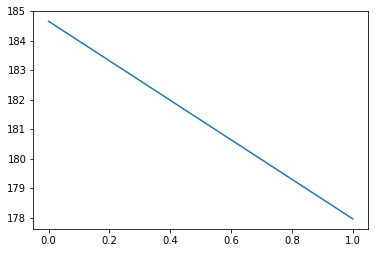

In [11]:
loss_list = np.array(loss_list)
avg_loss_list = np.mean(loss_list[:(len(loss_list)//1000)*1000].reshape(-1,1000), axis=1)
plt.plot(avg_loss_list)

In [ ]:
print(env.get_keys_to_action)

In [9]:
PATH = 'C:/Users/Frederik/Desktop/Gdoom/Model/saveV2.tar'
C:\Users\Frederik\Desktop\Deep learning

SyntaxError: unexpected character after line continuation character (<ipython-input-9-3d8173d331a7>, line 2)

In [10]:
allKills = []
allRewards = []
allTA = []
allLoss = []
Version = ['LR_00001-Gamma_90(3k_eps60k)', 'LR_00001-Gamma_95(3k_eps60k)', 'LR_00001-Gamma_99(3k_eps60k)', 'LR_0001-Gamma_90(3k_eps60k)', 'LR_0001-Gamma_95(3k_eps60k)', 'LR_0001-Gamma_99(3k_eps60k)', 'LR_001-Gamma_90(3k_eps60k)', 'LR_001-Gamma_95(3k_eps60k)', 'LR_001-Gamma_99(3k_eps60k)']
for i in Version:
    PATH = 'C:/Users/Frederik/Desktop/Deep learning/3k_eps60k/' + i + '.tar'#
    checkpoint = torch.load(PATH)
    allRewards.append(checkpoint['reward'])
    allLoss.append(checkpoint['loss'])
    allKills.append(checkpoint['kills'])
    allTA.append(checkpoint['timeAlive'])

allRewards = np.array(allRewards)
allLoss = np.array(allLoss)
allKills = np.array(allKills)
allTA = np.array(allTA)

In [11]:
for i in range(len(allKills)):
    print(Version[i] + ": ")
    print("Mean rewards: " + str(mean(allRewards[i])))
    print("Mean loss: " + str(mean(allLoss[i])))
    print("Mean kills in: " + str(mean(allKills[i])))
    print("Mean timeAlive: " + str(mean(allTA[i])))
    print(" ")

LR_00001-Gamma_90(3k_eps60k): 
Mean rewards: 9.955664055118959
Mean loss: 0.061842404035786946
Mean kills in: 7.099333333333333
Mean timeAlive: 108
 
LR_00001-Gamma_95(3k_eps60k): 
Mean rewards: 13.381262823005518
Mean loss: 0.07754273161672014
Mean kills in: 8.920666666666667
Mean timeAlive: 125
 
LR_00001-Gamma_99(3k_eps60k): 
Mean rewards: 10.935030752676228
Mean loss: 0.29576097311345406
Mean kills in: 7.341
Mean timeAlive: 116
 
LR_0001-Gamma_90(3k_eps60k): 
Mean rewards: 10.713797021448611
Mean loss: 0.04774023010557194
Mean kills in: 7.362
Mean timeAlive: 110
 
LR_0001-Gamma_95(3k_eps60k): 
Mean rewards: 12.359762836674848
Mean loss: 0.07135900634502218
Mean kills in: 8.204
Mean timeAlive: 119
 
LR_0001-Gamma_99(3k_eps60k): 
Mean rewards: 12.936930118441582
Mean loss: 0.1221889972654963
Mean kills in: 8.390666666666666
Mean timeAlive: 121
 
LR_001-Gamma_90(3k_eps60k): 
Mean rewards: 10.440330910146237
Mean loss: 0.059648473545266006
Mean kills in: 7.1803333333333335
Mean timeAli

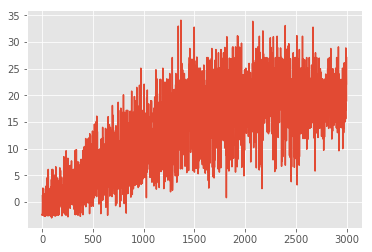

In [12]:
plt.plot(allRewards[1])

In [13]:
len(allRewards[1])

3000

In [14]:
meanRewards = []
reward = 0
for i in range(len(allRewards[1])):
    reward += allRewards[2][i]
    if i % 30 == 0:
        meanRewards.append(reward/30)
        reward = 0
        
    

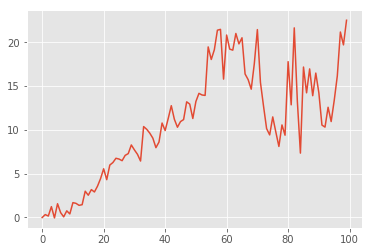

In [15]:
plt.plot(meanRewards)

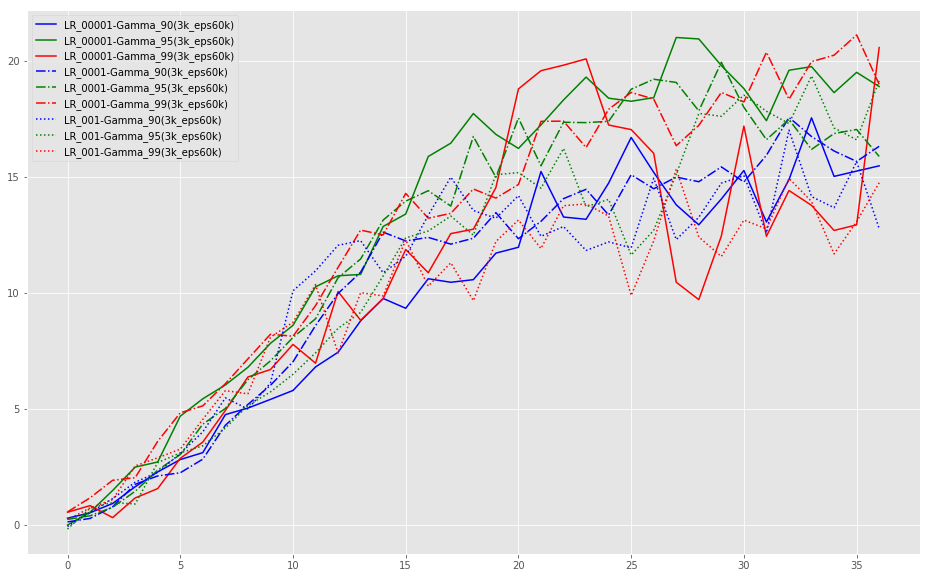

In [38]:
color = ["b","g","r","b","g","r","b","g","r"]
linestyle = ["-","-","-","-.","-.","-.",":",":",":"]
for i in range(len(allRewards)):
    loss_list = np.array(allRewards[i])
    avg_loss_list = np.mean(allRewards[i][:(len(allRewards[i])//80)*80].reshape(-1,80), axis=1)
    plt.plot(avg_loss_list,color = color[i],label= Version[i],linestyle = linestyle[i])
    plt.legend(loc = "upper left")
    #plt.title(str(mean(avg_loss_list)))
    #print(mean(avg_loss_list))
#plt.plot(meanRewards)